In [1]:
# =========================================================
# [Step 1] 구글 드라이브 마운트 & 환경 설정
# =========================================================
from google.colab import drive
drive.mount('/content/drive')

# YOLOv8 설치 (출력 메시지 숨김 -q)
!pip install ultralytics -q

# 필요한 라이브러리 임포트
import os
import glob
import shutil
import yaml
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from ultralytics import YOLO
from IPython.display import Image, display

print("1단계 완료: 환경 설정이 끝났습니다.")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
1단계 완료: 환경 설정이 끝났습니다.


In [ ]:
# =========================================================
# [Step 2] 데이터셋 구축 (NPY 좌표 -> YOLO TXT 변환)
# =========================================================

# 1. 경로 및 클래스 설정 (사용자님 경로 반영)
PROJECT_ROOT = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1"

SOURCE_PATHS = {
    "Fanta": f"{PROJECT_ROOT}/Raw_Data/Dataset_Fanta_Can",
    "Coke": f"{PROJECT_ROOT}/Raw_Data/Dataset_French_Coke_Can",
    "Coke_Light": f"{PROJECT_ROOT}/Raw_Data/Dataset_French_Coke_Light_Can",
    "Pepsi": f"{PROJECT_ROOT}/Raw_Data/Dataset_Pepsi_Can",
    "Pepsi_Max": f"{PROJECT_ROOT}/Raw_Data/Dataset_Pepsi_Max_Can"
}

CLASSES = ["Fanta", "Coke", "Coke_Light", "Pepsi", "Pepsi_Max"]
CLASS_MAP = {name: idx for idx, name in enumerate(CLASSES)}

# 코랩 내부에 만들 임시 학습 폴더 (속도 향상)
TEMP_DATASET_DIR = "/content/Temp_YOLO_Dataset"

# ---------------------------------------------------------

# 2. 초기화 (기존 폴더 삭제 후 재생성)
if os.path.exists(TEMP_DATASET_DIR): shutil.rmtree(TEMP_DATASET_DIR)
for split in ['train', 'val']:
    os.makedirs(f"{TEMP_DATASET_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{TEMP_DATASET_DIR}/labels/{split}", exist_ok=True)

# 3. 데이터 매칭 (PNG + NPY)
all_data_pairs = []
print("🔄 데이터 매칭을 시작합니다...")

for cls_name, folder_path in SOURCE_PATHS.items():
    if not os.path.exists(folder_path):
        print(f"⚠️ [주의] 폴더가 없습니다: {folder_path}")
        continue

    # .npy 파일(좌표) 찾기
    npy_files = glob.glob(os.path.join(folder_path, "*tight*.npy"))
    print(f"   📂 {cls_name}: 파일 스캔 중... (발견된 좌표 파일: {len(npy_files)}개)")

    match_count = 0
    for npy_path in npy_files:
        try:
            # 파일명에서 번호 추출 (예: bounding_box_2d_tight_0000.npy -> 0000)
            base_name = os.path.basename(npy_path)
            num_part = base_name.split('_')[-1].split('.')[0]

            # 짝꿍 이미지 경로 (rgb_0000.png)
            img_path = os.path.join(folder_path, f"rgb_{num_part}.png")

            # 이미지가 진짜로 있으면 리스트에 추가
            if os.path.exists(img_path):
                all_data_pairs.append({
                    'img': img_path,
                    'npy': npy_path,
                    'class_id': CLASS_MAP[cls_name],
                    'class_name': cls_name
                })
                match_count += 1
        except: continue
    print(f"      👉 {match_count}쌍 매칭 성공")

if len(all_data_pairs) == 0:
    raise ValueError("❌ 데이터가 하나도 없습니다! 폴더 경로와 파일명을 다시 확인해주세요.")

# 4. 학습/검증 데이터 분리
train_data, val_data = train_test_split(all_data_pairs, test_size=0.2, random_state=42, stratify=[d['class_name'] for d in all_data_pairs])

# 5. 변환 및 복사 함수
def process_batch(data_list, split_type):
    print(f"🚀 {split_type} 데이터셋 생성 중... ({len(data_list)}장)")
    for item in tqdm(data_list):
        try:
            # 이미지 복사 (이름 중복 방지: 클래스명_파일.png)
            filename = f"{item['class_name']}_{os.path.basename(item['img']).split('.')[0]}"
            target_img = f"{TEMP_DATASET_DIR}/images/{split_type}/{filename}.png"
            target_lbl = f"{TEMP_DATASET_DIR}/labels/{split_type}/{filename}.txt"

            shutil.copy(item['img'], target_img)

            # 좌표 변환 (NPY -> YOLO txt)
            img = cv2.imread(item['img'])
            h, w, _ = img.shape
            npy_data = np.load(item['npy'])

            with open(target_lbl, 'w') as f:
                for box in npy_data:
                    # 구조화된 배열(Structured Array) 처리
                    try:
                        x_min, y_min, x_max, y_max = box['x_min'], box['y_min'], box['x_max'], box['y_max']
                    except:
                        # 일반 배열 처리
                        x_min, y_min, x_max, y_max = box[0], box[1], box[2], box[3]

                    # 정규화 (0~1)
                    x_center = ((x_min + x_max) / 2) / w
                    y_center = ((y_min + y_max) / 2) / h
                    width = (x_max - x_min) / w
                    height = (y_max - y_min) / h

                    # 범위 클램핑 (0~1을 벗어나지 않도록 안전장치)
                    x_center = max(0, min(1, x_center))
                    y_center = max(0, min(1, y_center))
                    width = max(0, min(1, width))
                    height = max(0, min(1, height))

                    f.write(f"{item['class_id']} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
        except Exception as e:
            print(f"❌ 에러: {e}")

process_batch(train_data, 'train')
process_batch(val_data, 'val')

# 6. data.yaml 파일 생성
yaml_data = {
    'path': TEMP_DATASET_DIR,
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(CLASSES),
    'names': CLASSES
}
with open(f"{TEMP_DATASET_DIR}/data.yaml", 'w') as f:
    yaml.dump(yaml_data, f)

print(f"\n✅ 2단계 완료: 총 {len(all_data_pairs)}장의 학습 데이터가 준비되었습니다!")

🔄 데이터 매칭을 시작합니다...
   📂 Fanta: 파일 스캔 중... (발견된 좌표 파일: 150개)
      👉 150쌍 매칭 성공
   📂 Coke: 파일 스캔 중... (발견된 좌표 파일: 150개)
      👉 150쌍 매칭 성공
   📂 Coke_Light: 파일 스캔 중... (발견된 좌표 파일: 150개)
      👉 150쌍 매칭 성공
   📂 Pepsi: 파일 스캔 중... (발견된 좌표 파일: 150개)
      👉 150쌍 매칭 성공
   📂 Pepsi_Max: 파일 스캔 중... (발견된 좌표 파일: 150개)
      👉 150쌍 매칭 성공
🚀 train 데이터셋 생성 중... (600장)


  0%|          | 0/600 [00:00<?, ?it/s]

🚀 val 데이터셋 생성 중... (150장)


  0%|          | 0/150 [00:00<?, ?it/s]


✅ 2단계 완료: 총 750장의 학습 데이터가 준비되었습니다!


##2단계에서 생성한 증강 데이터 백업

In [ ]:
import shutil
import os
import datetime

# ================= [설정] =================
# 1. 방금 생성된 임시 폴더 (복사할 대상)
SOURCE_DIR = "/content/Temp_YOLO_Dataset"

# 2. 구글 드라이브 내 저장할 위치
# (헷갈리지 않게 날짜/시간을 폴더명에 붙여줍니다)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
TARGET_DIR = f"{PROJECT_ROOT}/Temp_YOLO_Dataset_{timestamp}"
# ==========================================

print(f"📦 백업을 시작합니다...")
print(f"   출발지: {SOURCE_DIR}")
print(f"   도착지: {TARGET_DIR}")

if os.path.exists(SOURCE_DIR):
    try:
        # 폴더 통째로 복사 (시간이 좀 걸릴 수 있습니다)
        shutil.copytree(SOURCE_DIR, TARGET_DIR)
        print(f"\n✅ 백업 완료! 구글 드라이브를 확인해보세요.")
        print(f"   저장된 위치: {TARGET_DIR}")
    except Exception as e:
        print(f"\n❌ 백업 실패: {e}")
else:
    print(f"\n❌ 에러: 원본 폴더({SOURCE_DIR})가 없습니다. 증강 코드를 먼저 실행해주세요.")

📦 백업을 시작합니다...
   출발지: /content/Temp_YOLO_Dataset
   도착지: /content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Temp_YOLO_Dataset_20260122_0105

✅ 백업 완료! 구글 드라이브를 확인해보세요.
   저장된 위치: /content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Temp_YOLO_Dataset_20260122_0105


##3단계 다시 시작

In [ ]:
# =========================================================
# [Step 3]데이터 증강 및 디버깅
# =========================================================

!pip install albumentations opencv-python-headless -q

import albumentations as A
import cv2
import os
import glob
import shutil
import numpy as np
import yaml
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# ================= [설정 구역] =================
PROJECT_ROOT = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1"

# 원본 데이터 경로 (Raw_Data)
SOURCE_PATHS = {
    "Fanta": f"{PROJECT_ROOT}/Raw_Data/Dataset_Fanta_Can",
    "Coke": f"{PROJECT_ROOT}/Raw_Data/Dataset_French_Coke_Can",
    "Coke_Light": f"{PROJECT_ROOT}/Raw_Data/Dataset_French_Coke_Light_Can",
    "Pepsi": f"{PROJECT_ROOT}/Raw_Data/Dataset_Pepsi_Can",
    "Pepsi_Max": f"{PROJECT_ROOT}/Raw_Data/Dataset_Pepsi_Max_Can"
}
CLASSES = ["Fanta", "Coke", "Coke_Light", "Pepsi", "Pepsi_Max"]

# 저장될 경로
OUTPUT_DIR = "/content/Augmented_YOLO_Dataset"
AUG_COUNT = 5  # 증강 배수
# ===============================================

# 1. 초기화
print("🧹 기존 폴더 정리 중...")
if os.path.exists(OUTPUT_DIR): shutil.rmtree(OUTPUT_DIR)
for split in ['train', 'val']:
    os.makedirs(f"{OUTPUT_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR}/labels/{split}", exist_ok=True)

# 2. 증강 파이프라인
transform = A.Compose([
    A.Rotate(limit=20, p=0.7),  # 70% 확률로 20도 이내 회전
    A.HorizontalFlip(p=0.5),    # 50% 확률로 좌우 반전
    A.RandomBrightnessContrast(p=0.5),  # 50% 확률로 밝기/대비 조절
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # 30% 확률로 노이즈(지직거림) 추가
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3))

class_map = {name: idx for idx, name in enumerate(CLASSES)}

# 3. 데이터 수집 및 검증 (여기가 핵심!)
all_data_pairs = []
print("\n🔍 [진단] 원본 데이터 경로 확인 및 파일 매칭...")

for cls_name, folder_path in SOURCE_PATHS.items():
    # 폴더 존재 여부 확인
    if not os.path.exists(folder_path):
        print(f"❌ [에러] 폴더가 없습니다: {folder_path}")
        continue

    # NPY 파일 검색
    npy_files = glob.glob(os.path.join(folder_path, "*tight*.npy"))
    if len(npy_files) == 0:
        print(f"⚠️ [경고] {cls_name}: 폴더는 있지만 .npy 파일이 0개입니다.")
        continue

    print(f"   📂 {cls_name}: {len(npy_files)}개의 좌표 파일 발견")

    # 짝꿍 이미지 찾기
    match_count = 0
    for npy_path in npy_files:
        # 파일명 분석 (bounding_box_2d_tight_0000.npy)
        base_name = os.path.basename(npy_path)
        try:
            num_part = base_name.split('_')[-1].split('.')[0] # 0000 추출
        except:
            print(f"      ❌ 파일명 분석 실패: {base_name}")
            continue

        # 이미지 경로 추정
        img_path = os.path.join(folder_path, f"rgb_{num_part}.png")

        if os.path.exists(img_path):
            all_data_pairs.append({
                'img': img_path, 'npy': npy_path,
                'class_id': class_map[cls_name], 'class_name': cls_name
            })
            match_count += 1
        else:
            # 첫 번째 실패 사례만 출력 (너무 많으면 시끄러우니까)
            if match_count == 0:
                print(f"      ⚠️ 이미지 매칭 실패 예시: {img_path} 없음")

    print(f"      👉 {match_count}쌍 매칭 성공")

if len(all_data_pairs) == 0:
    raise ValueError("❌ [치명적 오류] 매칭된 데이터가 0개입니다! 코드를 중단합니다.")

# 4. 학습/검증 분리
train_data, val_data = train_test_split(all_data_pairs, test_size=0.2, random_state=42, stratify=[d['class_name'] for d in all_data_pairs])

# 5. 증강 실행 함수
def process_augmentation(data_list, split_type, is_train=True):
    print(f"\n🚀 {split_type} 데이터 생성 시작 ({len(data_list)}장 -> 예상 {len(data_list) * (AUG_COUNT if is_train else 1)}장)")

    success_cnt = 0
    error_cnt = 0

    for item in tqdm(data_list):
        try:
            # 이미지 로드
            image = cv2.imread(item['img'])
            if image is None:
                print(f"❌ 이미지 로드 실패: {item['img']}")
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w, _ = image.shape

            # NPY 좌표 로드
            npy_data = np.load(item['npy'])
            bboxes = []

            for box in npy_data:
                # 필드명 접근 시도
                try:
                    x_min, y_min, x_max, y_max = box['x_min'], box['y_min'], box['x_max'], box['y_max']
                except:
                    x_min, y_min, x_max, y_max = box[0], box[1], box[2], box[3]

                # 정규화
                x_c = ((x_min + x_max) / 2) / w
                y_c = ((y_min + y_max) / 2) / h
                width = (x_max - x_min) / w
                height = (y_max - y_min) / h

                # 유효성 체크 (0~1 사이)
                if width > 0 and height > 0:
                    bboxes.append([x_c, y_c, width, height])

            # 증강 루프
            loop_range = range(AUG_COUNT) if is_train else range(1)

            for i in loop_range:
                if is_train:
                    augmented = transform(image=image, bboxes=bboxes, class_labels=[item['class_id']]*len(bboxes))
                    aug_img = augmented['image']
                    aug_bboxes = augmented['bboxes']
                else:
                    aug_img = image
                    aug_bboxes = bboxes

                if len(aug_bboxes) == 0: continue

                # 저장 이름 생성
                base_name = os.path.basename(item['img']).split('.')[0]
                file_prefix = f"{item['class_name']}_{base_name}_aug{i}"

                # 저장
                save_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
                cv2.imwrite(f"{OUTPUT_DIR}/images/{split_type}/{file_prefix}.jpg", save_img)

                with open(f"{OUTPUT_DIR}/labels/{split_type}/{file_prefix}.txt", "w") as f:
                    for bbox in aug_bboxes:
                        f.write(f"{item['class_id']} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
                success_cnt += 1

        except Exception as e:
            error_cnt += 1
            print(f"❌ 처리 중 에러 ({os.path.basename(item['img'])}): {e}")

    print(f"✅ {split_type} 완료: 성공 {success_cnt}장 / 실패 {error_cnt}장")

# 실행
process_augmentation(train_data, 'train', is_train=True)
process_augmentation(val_data, 'val', is_train=False)

# YAML 생성
yaml_data = {'path': OUTPUT_DIR, 'train': 'images/train', 'val': 'images/val', 'nc': len(CLASSES), 'names': CLASSES}
with open(f"{OUTPUT_DIR}/data.yaml", 'w') as f:
    yaml.dump(yaml_data, f)

# 최종 확인
total_files = len(glob.glob(f"{OUTPUT_DIR}/images/train/*.jpg")) + len(glob.glob(f"{OUTPUT_DIR}/images/val/*.jpg"))
print(f"\n🎉 [최종 결과] 총 {total_files}장의 증강 데이터가 생성되었습니다.")
if total_files > 0:
    print(f"📂 저장 위치: {OUTPUT_DIR}")
else:
    print("❌ 여전히 파일이 생성되지 않았습니다. 위 에러 로그를 확인해주세요.")

🧹 기존 폴더 정리 중...

🔍 [진단] 원본 데이터 경로 확인 및 파일 매칭...
   📂 Fanta: 150개의 좌표 파일 발견
      👉 150쌍 매칭 성공
   📂 Coke: 150개의 좌표 파일 발견
      👉 150쌍 매칭 성공
   📂 Coke_Light: 150개의 좌표 파일 발견
      👉 150쌍 매칭 성공
   📂 Pepsi: 150개의 좌표 파일 발견
      👉 150쌍 매칭 성공
   📂 Pepsi_Max: 150개의 좌표 파일 발견
      👉 150쌍 매칭 성공

🚀 train 데이터 생성 시작 (600장 -> 예상 3000장)


/tmp/ipython-input-1837672136.py:47: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


  0%|          | 0/600 [00:00<?, ?it/s]

✅ train 완료: 성공 3000장 / 실패 0장

🚀 val 데이터 생성 시작 (150장 -> 예상 150장)


  0%|          | 0/150 [00:00<?, ?it/s]

✅ val 완료: 성공 150장 / 실패 0장

🎉 [최종 결과] 총 3150장의 증강 데이터가 생성되었습니다.
📂 저장 위치: /content/Augmented_YOLO_Dataset


In [ ]:
# =========================================================
# 증강 데이터 백업
# =========================================================
import shutil
import os
import datetime

# ================= [설정] =================
PROJECT_ROOT = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1"

# 후보군 (증강 폴더 우선)
DIR_AUG = "/content/Augmented_YOLO_Dataset"
DIR_TEMP = "/content/Temp_YOLO_Dataset"
# ==========================================

# 1. 어디에 데이터가 있는지 확인 (진단)
def get_valid_source():
    # 증강 폴더 확인
    if os.path.exists(DIR_AUG) and len(glob.glob(f"{DIR_AUG}/images/train/*.jpg")) > 0:
        return DIR_AUG, "Augmented_Dataset"
    # 기본 폴더 확인
    if os.path.exists(DIR_TEMP) and len(glob.glob(f"{DIR_TEMP}/images/train/*.png")) > 0:
        return DIR_TEMP, "Basic_Dataset"
    return None, None

source_dir, dir_name = get_valid_source()

print(f"🔍 데이터 진단 중...")

if source_dir:
    print(f"✅ 백업할 데이터를 찾았습니다: {source_dir}")

    # 2. 압축하기 (Colab 내부에서 진행하므로 빠름)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    zip_filename = f"{dir_name}_{timestamp}" # 확장자는 shutil이 붙여줌 (.zip)
    zip_path = f"/content/{zip_filename}"

    print(f"📦 데이터를 압축하는 중... (잠시만 기다려주세요)")
    shutil.make_archive(zip_path, 'zip', source_dir)

    # 3. 드라이브로 전송 (파일 1개라 누락 없음)
    final_zip_name = f"{zip_filename}.zip"
    drive_dest = os.path.join(PROJECT_ROOT, final_zip_name)

    print(f"🚀 압축 파일({final_zip_name})을 구글 드라이브로 전송합니다...")
    shutil.copy(f"{zip_path}.zip", drive_dest)

    if os.path.exists(drive_dest):
        print(f"\n🎉 [성공] 백업이 완료되었습니다!")
        print(f"   📂 저장 위치: {drive_dest}")
        print(f"   👉 이제 드라이브에서 '{final_zip_name}' 파일을 확인해보세요.")
    else:
        print(f"\n❌ [실패] 복사 명령은 내렸으나 파일이 보이지 않습니다. 잠시 후 드라이브를 새로고침 해보세요.")

else:
    print("\n❌ [오류] 백업할 데이터가 없습니다!")
    print("   Augmented 폴더와 Temp 폴더가 모두 비어있거나 존재하지 않습니다.")
    print("   👉 증강 코드(3단계)나 변환 코드(2단계)를 다시 실행해서 데이터를 먼저 만들어주세요.")

🔍 데이터 진단 중...
✅ 백업할 데이터를 찾았습니다: /content/Augmented_YOLO_Dataset
📦 데이터를 압축하는 중... (잠시만 기다려주세요)
🚀 압축 파일(Augmented_Dataset_20260122_0112.zip)을 구글 드라이브로 전송합니다...

🎉 [성공] 백업이 완료되었습니다!
   📂 저장 위치: /content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Augmented_Dataset_20260122_0112.zip
   👉 이제 드라이브에서 'Augmented_Dataset_20260122_0112.zip' 파일을 확인해보세요.


In [ ]:
# =========================================================
# [Step 4] 모델 학습 시작
# =========================================================
from ultralytics import YOLO
import os

# ================= [설정] =================
# 모델 이름 (나중에 결과가 이 이름의 폴더에 저장됩니다)
MODEL_NAME = 'Can_Detector_Final'
# ==========================================

# 1. 학습할 데이터셋 자동 선택 (증강 데이터 우선!)
# 증강된 데이터가 있다면 무조건 이걸 쓰는 게 성능이 좋습니다.
if os.path.exists("/content/Augmented_YOLO_Dataset/data.yaml"):
    DATA_PATH = "/content/Augmented_YOLO_Dataset/data.yaml"
    print("✅ [Best] '증강 데이터셋(Augmented)'을 발견했습니다! 이걸로 학습합니다.")
elif os.path.exists("/content/Temp_YOLO_Dataset/data.yaml"):
    DATA_PATH = "/content/Temp_YOLO_Dataset/data.yaml"
    print("⚠️ [Normal] 증강 데이터가 없어 '기본 데이터셋(Temp)'으로 학습합니다.")
else:
    print("❌ [Error] 학습할 데이터가 없습니다.")
    print("   (코랩이 꺼졌다면 백업해둔 zip 파일을 업로드하고 압축을 풀어야 합니다)")
    DATA_PATH = None

# 2. 학습 실행
if DATA_PATH:
    # YOLOv8 nano 모델 로드 (가볍고 빠름)
    model = YOLO('yolov8n.pt')

    print(f"\n🔥 학습을 시작합니다! (약 10~20분 소요됩니다)")
    print(f"   ▶ 대상 데이터: {DATA_PATH}")

    model.train(
        data=DATA_PATH,
        epochs=50,       # 50번 반복
        imgsz=640,       # 이미지 크기
        batch=16,        # 한 번에 16장씩 처리
        name=MODEL_NAME, # 결과 저장 폴더 이름
        exist_ok=True    # 덮어쓰기 허용
    )

    print("\n🎉 학습 완료! 'best.pt' 모델 파일이 생성되었습니다.")

✅ [Best] '증강 데이터셋(Augmented)'을 발견했습니다! 이걸로 학습합니다.

🔥 학습을 시작합니다! (약 10~20분 소요됩니다)
   ▶ 대상 데이터: /content/Augmented_YOLO_Dataset/data.yaml
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Augmented_YOLO_Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, mult

📊 AI의 학습 결과 (정답 vs 예측 비교):


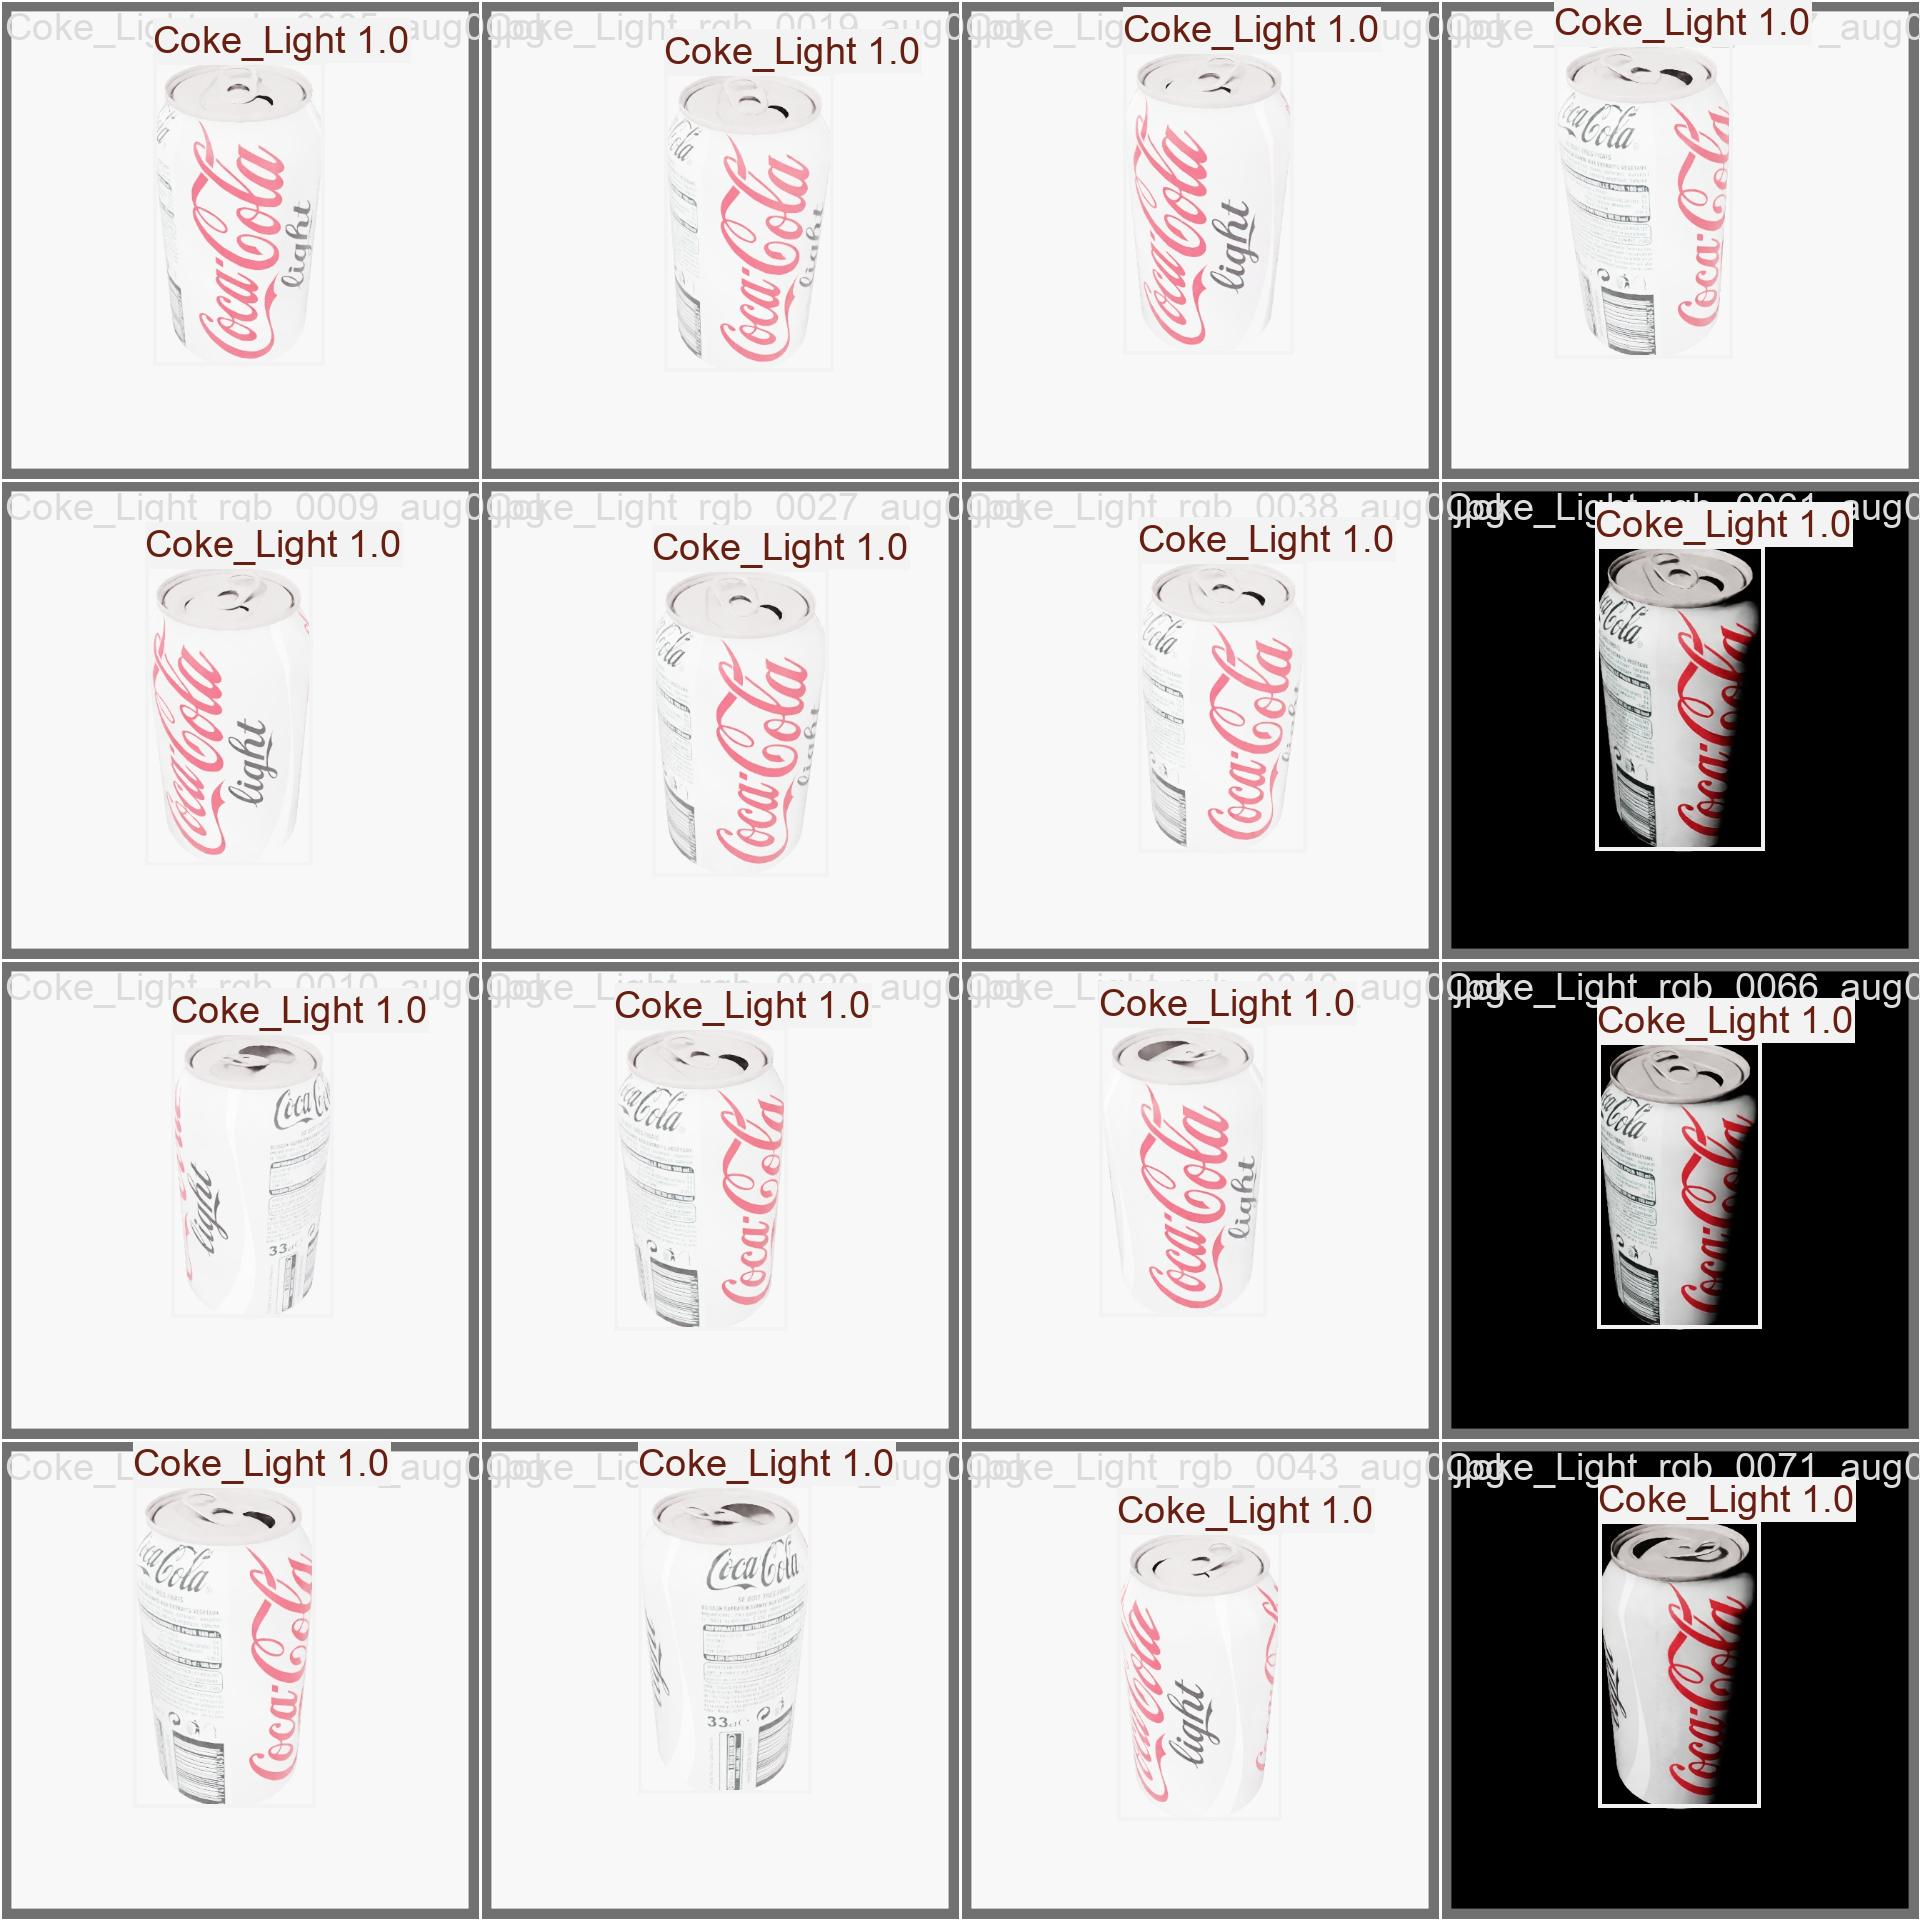


💾 모델 저장 성공!
   📂 내 드라이브 위치: /content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Models/best.pt


In [ ]:
# =========================================================
# [Step 5] 결과 확인 및 모델 다운로드 (경로 수정 완료)
# =========================================================
import glob
import os
import shutil
from IPython.display import Image, display

# 1. 설정 (3단계와 이름을 똑같이 맞춰야 합니다!)
MODEL_NAME = 'Can_Detector_Final'
PROJECT_ROOT = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1"

# ---------------------------------------------------------

# 2. 검증 이미지 확인 (AI가 푼 문제지 채점표 보기)
# 학습이 끝나면 'val_batch0_pred.jpg'라는 이름으로 결과가 생성됩니다.
pred_image_path = f"/content/runs/detect/{MODEL_NAME}/val_batch0_pred.jpg"

if os.path.exists(pred_image_path):
    print("📊 AI의 학습 결과 (정답 vs 예측 비교):")
    display(Image(filename=pred_image_path, width=800))
else:
    print(f"⚠️ 결과 이미지를 찾을 수 없습니다: {pred_image_path}")
    print("   (학습이 아직 안 끝났거나, 에러가 났을 수 있습니다)")

# 3. 모델 파일(best.pt)을 내 구글 드라이브로 백업
source_model = f"/content/runs/detect/{MODEL_NAME}/weights/best.pt"
target_dir = f"{PROJECT_ROOT}/Models"

# 폴더가 없으면 만들기
os.makedirs(target_dir, exist_ok=True)

if os.path.exists(source_model):
    # 파일 복사
    shutil.copy(source_model, f"{target_dir}/best.pt")
    print("\n" + "="*40)
    print(f"💾 모델 저장 성공!")
    print(f"   📂 내 드라이브 위치: {target_dir}/best.pt")
    print("="*40)
else:
    print(f"\n❌ 모델 파일이 생성되지 않았습니다: {source_model}")

✅ 학습된 모델을 로드합니다: /content/runs/detect/Can_Detector_Final/weights/best.pt
✅ '증강 데이터셋(Augmented)'에서 테스트 이미지를 가져옵니다.

🔍 5장의 이미지를 테스트합니다...


0: 640x640 1 Coke_Light, 13.4ms
1: 640x640 1 Fanta, 13.4ms
2: 640x640 1 Pepsi, 13.4ms
3: 640x640 1 Coke, 13.4ms
4: 640x640 1 Pepsi, 13.4ms
Speed: 3.0ms preprocess, 13.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict

      🖼️ 테스트 결과 확인      



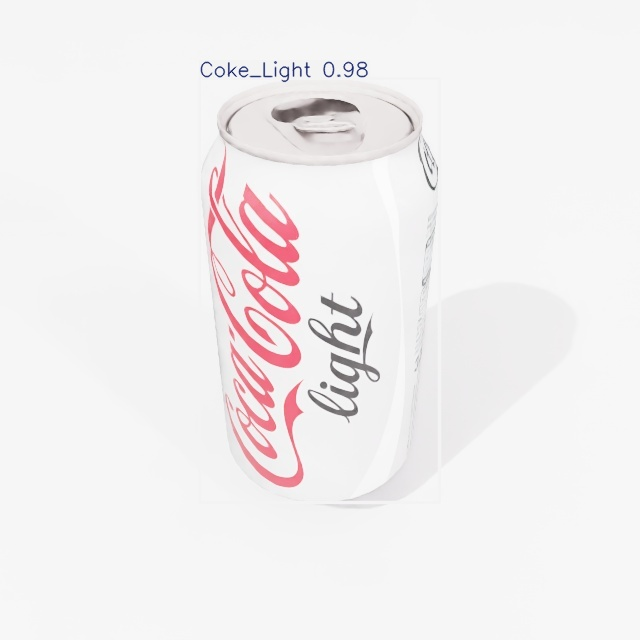

👆 Coke_Light_rgb_0113_aug0.jpg



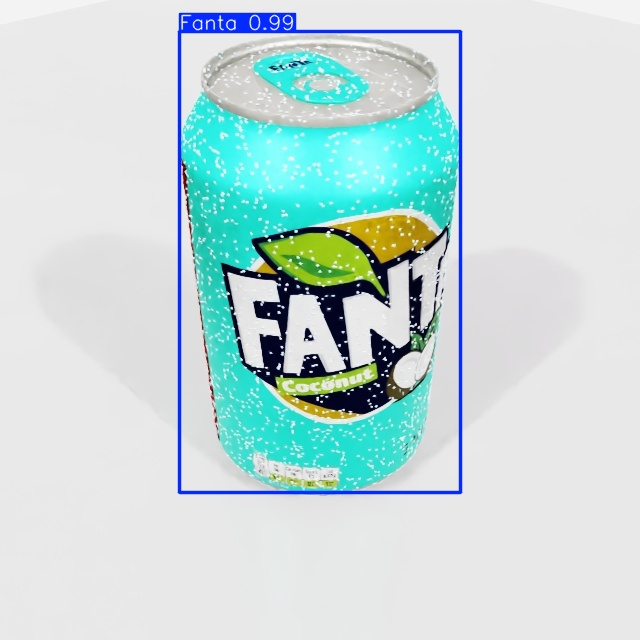

👆 Fanta_rgb_0146_aug0.jpg



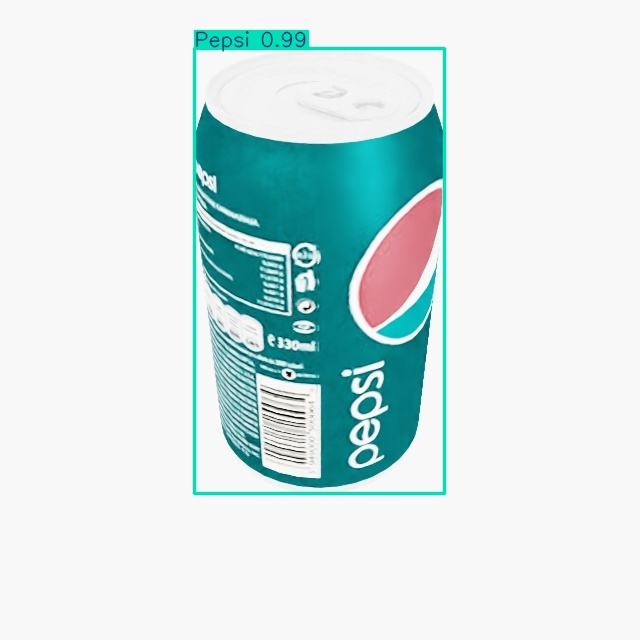

👆 Pepsi_rgb_0040_aug0.jpg



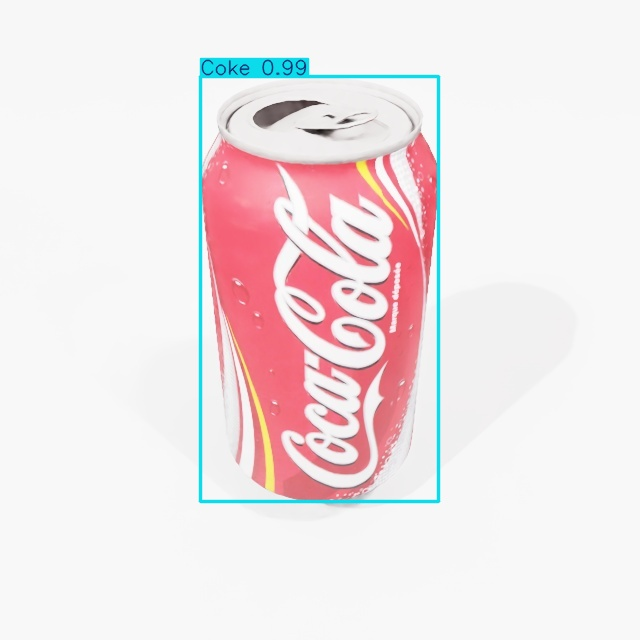

👆 Coke_rgb_0132_aug0.jpg



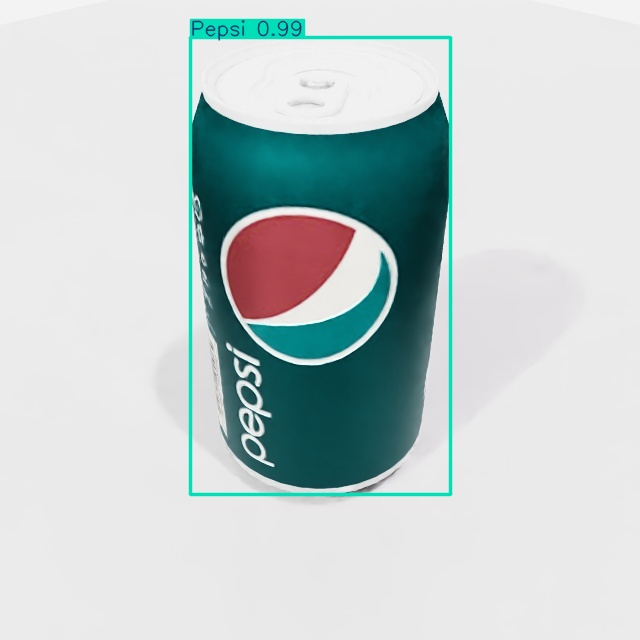

👆 Pepsi_rgb_0112_aug0.jpg

🎉 축하합니다! 박스가 캔 위에 정확히 쳐져 있다면 성공입니다.


In [ ]:
# =========================================================
# [Step 5] 학습된 모델 테스트 (Inference) - 수정 완료
# =========================================================

import glob
import random
import os
import cv2
from ultralytics import YOLO
from IPython.display import Image, display

# 1. 설정 (3, 4단계와 이름 통일!)
MODEL_NAME = 'Can_Detector_Final'

# 모델 경로 자동 생성
MODEL_PATH = f"/content/runs/detect/{MODEL_NAME}/weights/best.pt"

if not os.path.exists(MODEL_PATH):
    print(f"❌ 모델 파일이 없습니다: {MODEL_PATH}")
    print("👉 3단계(학습)가 아직 안 끝났거나, 이름이 다를 수 있습니다.")
else:
    print(f"✅ 학습된 모델을 로드합니다: {MODEL_PATH}")
    model = YOLO(MODEL_PATH)

    # 2. 테스트할 이미지 폴더 찾기 (증강 데이터 우선!)
    if os.path.exists("/content/Augmented_YOLO_Dataset/images/val"):
        VAL_IMAGE_DIR = "/content/Augmented_YOLO_Dataset/images/val"
        print("✅ '증강 데이터셋(Augmented)'에서 테스트 이미지를 가져옵니다.")
    elif os.path.exists("/content/Temp_YOLO_Dataset/images/val"):
        VAL_IMAGE_DIR = "/content/Temp_YOLO_Dataset/images/val"
        print("⚠️ '기본 데이터셋(Temp)'에서 테스트 이미지를 가져옵니다.")
    else:
        VAL_IMAGE_DIR = None

    # 이미지 파일 리스트업
    if VAL_IMAGE_DIR:
        test_images = glob.glob(os.path.join(VAL_IMAGE_DIR, "*.jpg")) + glob.glob(os.path.join(VAL_IMAGE_DIR, "*.png"))
    else:
        test_images = []

    # 3. 테스트 실행
    if len(test_images) == 0:
        print("❌ 테스트할 이미지가 없습니다. (데이터셋 폴더 확인 필요)")
    else:
        # 랜덤으로 5장 뽑기
        selected_imgs = random.sample(test_images, min(5, len(test_images)))

        print(f"\n🔍 {len(selected_imgs)}장의 이미지를 테스트합니다...\n")

        # 추론 실행 (Confidence 0.5 이상만)
        # save=True: runs/detect/predict 폴더에 저장됨
        results = model.predict(selected_imgs, save=True, conf=0.5, imgsz=640)

        print("\n" + "="*30)
        print("      🖼️ 테스트 결과 확인      ")
        print("="*30 + "\n")

        # 결과 시각화 (메모리에서 바로 출력 - 더 안정적임)
        for i, r in enumerate(results):
            # 원본 파일명
            org_filename = os.path.basename(selected_imgs[i])

            # 박스 그려진 이미지 생성
            im_array = r.plot()

            # 코랩 화면에 출력
            display(Image(data=cv2.imencode('.jpg', im_array)[1].tobytes(), width=400))
            print(f"👆 {org_filename}\n")

        print("🎉 축하합니다! 박스가 캔 위에 정확히 쳐져 있다면 성공입니다.")

파일경로 찾기

In [ ]:
import os
import glob

# 1. 구글 드라이브 마운트 (이미 되어있어도 다시 확인)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2. 검색 시작 위치 (여기서부터 아래로 훑습니다)
SEARCH_ROOT = "/content/drive/MyDrive"

print(f"🔍 '{SEARCH_ROOT}' 내부에서 데이터 폴더를 찾는 중입니다...")
print("잠시만 기다려주세요 (파일이 많으면 오래 걸릴 수 있습니다)...")

# 'Dataset_'으로 시작하는 폴더를 모두 찾습니다.
found_folders = glob.glob(os.path.join(SEARCH_ROOT, "**", "Dataset_*"), recursive=True)

if not found_folders:
    print("❌ 'Dataset_'으로 시작하는 폴더를 하나도 못 찾았습니다!")
    print("폴더 이름이 'Dataset_Fanta_Can' 처럼 되어있는지,")
    print("혹은 '/content/drive/MyDrive/Doosan_Robotics_project' 경로가 맞는지 확인해주세요.")
else:
    print(f"✅ 총 {len(found_folders)}개의 폴더를 찾았습니다!")
    print("-" * 50)

    # 찾은 폴더들 안에 png 파일이 있는지 검사
    valid_folders = {}
    for folder in found_folders:
        png_count = len(glob.glob(os.path.join(folder, "*.png")))
        if png_count > 0:
            folder_name = os.path.basename(folder)
            print(f"📂 발견: {folder_name} (이미지 {png_count}장)")
            print(f"   👉 전체 경로: {folder}")
            valid_folders[folder_name] = folder
        else:
            print(f"⚠️ 빈 폴더 (무시됨): {folder}")

    print("-" * 50)

    if len(valid_folders) > 0:
        print("💡 [해결책] 위에서 출력된 '전체 경로'를 복사해서 SOURCE_PATHS 코드를 수정하세요.")
        print("예시:")
        print("SOURCE_PATHS = {")
        for name, path in valid_folders.items():
             # 클래스 이름 추측 (Fanta_Can -> Fanta)
             class_guess = name.replace("Dataset_", "").replace("_Can", "")
             print(f'    "{class_guess}": "{path}",')
        print("}")
    else:
        print("❌ 폴더는 찾았지만, 안에 .png 파일이 없습니다. 아이작 심에서 저장이 안 된 것 같습니다.")

Mounted at /content/drive
🔍 '/content/drive/MyDrive' 내부에서 데이터 폴더를 찾는 중입니다...
잠시만 기다려주세요 (파일이 많으면 오래 걸릴 수 있습니다)...
✅ 총 11개의 폴더를 찾았습니다!
--------------------------------------------------
⚠️ 빈 폴더 (무시됨): /content/drive/MyDrive/Doosan_Robotics_project/Dataset_Cans.zip
📂 발견: Dataset_Pepsi_Can (이미지 200장)
   👉 전체 경로: /content/drive/MyDrive/Doosan_Robotics_project/raw_data/Dataset_Pepsi_Can
📂 발견: Dataset_French_Coke_Can (이미지 200장)
   👉 전체 경로: /content/drive/MyDrive/Doosan_Robotics_project/raw_data/Dataset_French_Coke_Can
📂 발견: Dataset_French_Coke_Light_Can (이미지 200장)
   👉 전체 경로: /content/drive/MyDrive/Doosan_Robotics_project/raw_data/Dataset_French_Coke_Light_Can
📂 발견: Dataset_Pepsi_Max_Can (이미지 200장)
   👉 전체 경로: /content/drive/MyDrive/Doosan_Robotics_project/raw_data/Dataset_Pepsi_Max_Can
📂 발견: Dataset_Fanta_Can (이미지 200장)
   👉 전체 경로: /content/drive/MyDrive/Doosan_Robotics_project/raw_data/Dataset_Fanta_Can
📂 발견: Dataset_Fanta_Can (이미지 150장)
   👉 전체 경로: /content/drive/MyDrive/Doosan_Robotics_p

In [ ]:
import os
import glob

# Fanta 폴더 하나만 딱 찝어서 확인해봅니다.
test_folder = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Raw_Data/Dataset_Fanta_Can"

print(f"📂 폴더 검사 중: {test_folder}")

if os.path.exists(test_folder):
    pngs = sorted(glob.glob(os.path.join(test_folder, "*.png")))
    jsons = sorted(glob.glob(os.path.join(test_folder, "*.json")))

    print(f"📸 이미지 파일(.png): {len(pngs)}개 발견")
    print(f"📝 라벨 파일(.json): {len(jsons)}개 발견")

    print("-" * 30)
    if len(pngs) > 0:
        print(f"예시 이미지 이름: {os.path.basename(pngs[0])}")
    else:
        print("이미지가 없습니다!")

    if len(jsons) > 0:
        print(f"예시 라벨 이름:   {os.path.basename(jsons[0])}")
    else:
        print("❌ 라벨(JSON) 파일이 하나도 없습니다! 드라이브에 업로드 하셨나요?")

    print("-" * 30)

    # 이름 비교
    if len(pngs) > 0 and len(jsons) > 0:
        img_base = os.path.splitext(os.path.basename(pngs[0]))[0] # rgb_0000
        json_base = os.path.splitext(os.path.basename(jsons[0]))[0] # rgb_0000 혹은 bounding_box...

        if img_base == json_base:
            print("✅ 파일 이름이 서로 일치합니다. (왜 에러가 났지?)")
        else:
            print("⚠️ 파일 이름이 서로 다릅니다!")
            print(f"   이미지는 '{img_base}'를 찾는데, 라벨은 '{json_base}' 입니다.")
            print("👉 코드를 수정해야 합니다.")
else:
    print("❌ 폴더 경로 자체가 잘못되었습니다.")

📂 폴더 검사 중: /content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Raw_Data/Dataset_Fanta_Can
📸 이미지 파일(.png): 150개 발견
📝 라벨 파일(.json): 300개 발견
------------------------------
예시 이미지 이름: rgb_0000.png
예시 라벨 이름:   bounding_box_2d_tight_labels_0000.json
------------------------------
⚠️ 파일 이름이 서로 다릅니다!
   이미지는 'rgb_0000'를 찾는데, 라벨은 'bounding_box_2d_tight_labels_0000' 입니다.
👉 코드를 수정해야 합니다.


json 파일 명 변경 코드

In [ ]:
import os
import glob
import shutil

# 1. 데이터가 있는 메인 경로
PROJECT_ROOT = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Raw_Data"

# 2. 정리할 폴더들 이름
TARGET_FOLDERS = [
    "Dataset_Fanta_Can",
    "Dataset_French_Coke_Can",
    "Dataset_French_Coke_Light_Can",
    "Dataset_Pepsi_Can",
    "Dataset_Pepsi_Max_Can"
]

# 3. 변경할 지저분한 패턴들 (이 3가지 종류를 찾아냅니다)
PATTERNS = [
    "bounding_box_2d_tight_labels_",     # 패턴 1
    "bounding_box_2d_tight_prim_paths_", # 패턴 2
    "bounding_box_2d_tight_"             # 패턴 3 (가장 짧은 건 마지막에)
]

print("🔄 파일 이름 통일 작업을 시작합니다...")

for folder_name in TARGET_FOLDERS:
    folder_path = os.path.join(PROJECT_ROOT, folder_name)

    if not os.path.exists(folder_path):
        print(f"⚠️ 폴더 없음 (건너뜀): {folder_path}")
        continue

    print(f"📂 폴더 정리 중: {folder_name}")

    # 해당 폴더의 모든 json 파일 가져오기
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    count = 0

    for json_path in json_files:
        dir_name = os.path.dirname(json_path)
        file_name = os.path.basename(json_path)

        # 이미 이름이 rgb_로 바뀐건 건너뜀
        if file_name.startswith("rgb_"):
            continue

        # 3가지 패턴 중 하나라도 포함되어 있는지 확인
        matched = False
        for pattern in PATTERNS:
            if file_name.startswith(pattern):
                # 패턴 제거하고 숫자만 추출 (예: ...labels_0050.json -> 0050)
                try:
                    # 파일명 끝부분 숫자 추출 로직
                    # '_'로 쪼개서 맨 마지막 덩어리가 숫자+확장자임
                    number_part = file_name.split('_')[-1].split('.')[0]

                    # 새 이름 만들기 (rgb_0050.json)
                    new_name = f"rgb_{number_part}.json"
                    new_path = os.path.join(dir_name, new_name)

                    # 이름 변경 실행!
                    os.rename(json_path, new_path)
                    count += 1
                    matched = True
                    break # 하나 찾았으면 다음 파일로
                except Exception as e:
                    print(f"   ❌ 변환 실패: {file_name} / 에러: {e}")

        if not matched:
            # 패턴 3개에 해당 안되는 이상한 파일일 경우
            pass

    print(f"   ✅ {count}개의 JSON 파일 이름을 'rgb_XXXX.json'으로 변경했습니다.")

print("-" * 50)
print("🎉 모든 작업 완료! 이제 파일 이름이 rgb_XXXX.png / rgb_XXXX.json 으로 통일되었습니다.")

🔄 파일 이름 통일 작업을 시작합니다...
📂 폴더 정리 중: Dataset_Fanta_Can
   ✅ 300개의 JSON 파일 이름을 'rgb_XXXX.json'으로 변경했습니다.
📂 폴더 정리 중: Dataset_French_Coke_Can
   ✅ 150개의 JSON 파일 이름을 'rgb_XXXX.json'으로 변경했습니다.
📂 폴더 정리 중: Dataset_French_Coke_Light_Can
   ✅ 300개의 JSON 파일 이름을 'rgb_XXXX.json'으로 변경했습니다.
📂 폴더 정리 중: Dataset_Pepsi_Can
   ✅ 300개의 JSON 파일 이름을 'rgb_XXXX.json'으로 변경했습니다.
📂 폴더 정리 중: Dataset_Pepsi_Max_Can
   ✅ 300개의 JSON 파일 이름을 'rgb_XXXX.json'으로 변경했습니다.
--------------------------------------------------
🎉 모든 작업 완료! 이제 파일 이름이 rgb_XXXX.png / rgb_XXXX.json 으로 통일되었습니다.


파일 진단 코드

In [ ]:
import json
import cv2
import glob
import os
import numpy as np

# ================= [진단 설정] =================
PROJECT_ROOT = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1"
TEST_CLASS = "Fanta" # 문제가 되는 클래스 중 하나 선택
TEST_FOLDER = f"{PROJECT_ROOT}/Raw_Data/Dataset_{TEST_CLASS}_Can"
# ===============================================

print(f"🕵️ '{TEST_CLASS}' 폴더 진단을 시작합니다...")

# 1. 파일 존재 확인
if not os.path.exists(TEST_FOLDER):
    print(f"❌ [치명적 오류] 폴더가 없습니다: {TEST_FOLDER}")
else:
    img_files = glob.glob(os.path.join(TEST_FOLDER, "*.png"))
    print(f"✅ 폴더 발견! 이미지 파일: {len(img_files)}장")

    if len(img_files) > 0:
        # 첫 번째 파일만 샘플로 가져오기
        test_img_path = img_files[0]
        test_json_path = test_img_path.replace(".png", ".json")

        print(f"\n📄 샘플 파일 분석:")
        print(f"   - 이미지: {os.path.basename(test_img_path)}")
        print(f"   - JSON:  {os.path.basename(test_json_path)}")

        # 2. JSON 존재 확인
        if not os.path.exists(test_json_path):
            print("❌ [오류] 짝이 맞는 JSON 파일이 없습니다! 이름이 'rgb_XXXX.json'으로 통일되었나요?")
        else:
            # 3. JSON 내용 뜯어보기
            with open(test_json_path, 'r') as f:
                data = json.load(f)

            print(f"\n🔍 JSON 내부 키(Key) 검사:")
            found_key = next((k for k in data if 'bounding_box_2d_tight' in k), None)

            if found_key:
                print(f"   ✅ 타겟 키 발견: '{found_key}'")
                box_data = data[found_key]
                print(f"   📊 데이터 개수: {len(box_data)}개")

                if len(box_data) > 0:
                    raw_box = box_data[0] # 첫 번째 박스 [xmin, ymin, xmax, ymax]
                    print(f"   🔢 원본 좌표 데이터(첫번째): {raw_box}")

                    # 4. 이미지 로드 및 좌표 변환 테스트
                    img = cv2.imread(test_img_path)
                    if img is None:
                        print("❌ [오류] cv2.imread가 이미지를 읽지 못했습니다. 경로에 한글이 있거나 파일이 깨졌습니다.")
                    else:
                        h, w, _ = img.shape
                        print(f"   🖼️ 이미지 크기: w={w}, h={h}")

                        # 변환 로직 시뮬레이션
                        x_min, y_min, x_max, y_max = raw_box[0], raw_box[1], raw_box[2], raw_box[3]

                        print(f"   🧮 좌표 변환 시뮬레이션:")
                        print(f"      원본: {x_min}, {y_min}, {x_max}, {y_max}")

                        # 클램핑 (이미지 밖으로 나가는지 확인)
                        x_min_c = max(0, min(x_min, w - 1))
                        y_min_c = max(0, min(y_min, h - 1))
                        x_max_c = max(0, min(x_max, w - 1))
                        y_max_c = max(0, min(y_max, h - 1))

                        print(f"      보정후: {x_min_c}, {y_min_c}, {x_max_c}, {y_max_c}")

                        if x_max_c <= x_min_c or y_max_c <= y_min_c:
                            print("❌ [원인 발견!] 좌표 유효성 검사 탈락.")
                            print("      이유: 박스의 폭이나 높이가 0 이하입니다. (좌표가 이상하거나 이미지 범위를 벗어남)")
                        else:
                            print("✅ [정상] 좌표 변환 성공! 이 데이터는 정상적으로 저장되어야 합니다.")
                            print("❓ 그런데도 파일이 안 생긴다면, 저장 경로(LOCAL_DATASET_DIR) 권한 문제일 수 있습니다.")
                else:
                    print("⚠️ [경고] JSON 안에 박스 데이터가 비어있습니다 ([]).")
            else:
                print("❌ [원인 발견!] 'bounding_box_2d_tight'가 포함된 키를 찾을 수 없습니다.")
                print(f"      현재 JSON 키 목록: {list(data.keys())}")

🕵️ 'Fanta' 폴더 진단을 시작합니다...
✅ 폴더 발견! 이미지 파일: 150장

📄 샘플 파일 분석:
   - 이미지: rgb_0064.png
   - JSON:  rgb_0064.json
❌ [오류] 짝이 맞는 JSON 파일이 없습니다! 이름이 'rgb_XXXX.json'으로 통일되었나요?


진단코드

In [ ]:
import json
import os
import glob
import cv2

# ================= [설정] =================
PROJECT_ROOT = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1"
TEST_FOLDER = f"{PROJECT_ROOT}/Raw_Data/Dataset_Fanta_Can"  # Fanta 폴더 테스트
# ==========================================

print("🕵️ JSON 데이터 구조 정밀 분석 중...")

# 1. 파일 하나 가져오기
json_files = glob.glob(os.path.join(TEST_FOLDER, "*.json"))
if not json_files:
    print("❌ JSON 파일이 없습니다.")
else:
    target_json = json_files[0]
    target_img = target_json.replace(".json", ".png")

    print(f"📄 분석 대상: {os.path.basename(target_json)}")

    with open(target_json, 'r') as f:
        data = json.load(f)

    # 2. 데이터 구조 확인 (리스트인지 딕셔너리인지)
    print(f"🔍 데이터 타입: {type(data)}")

    # 리스트면 껍질 벗기기
    if isinstance(data, list):
        print("⚠️ 리스트([]) 구조 감지! 첫 번째 요소를 꺼냅니다.")
        if len(data) > 0:
            data = data[0]
            print(f"   👉 내부 데이터 타입: {type(data)}")
        else:
            print("❌ 빈 리스트([])입니다. 데이터가 없습니다.")
            data = {}

    # 3. 키(Key) 확인
    if isinstance(data, dict):
        keys = list(data.keys())
        print(f"🔑 포함된 키 목록: {keys}")

        # 'bounding_box'가 들어간 키 찾기
        target_key = next((k for k in keys if 'bounding_box_2d_tight' in k), None)

        if target_key:
            print(f"✅ 타겟 키 발견: '{target_key}'")
            coords = data[target_key]
            print(f"📊 좌표 데이터 개수: {len(coords)}개")

            if len(coords) > 0:
                raw_box = coords[0]
                print(f"🔢 첫 번째 좌표 값: {raw_box}")

                # 이미지 크기 확인
                if os.path.exists(target_img):
                    img = cv2.imread(target_img)
                    if img is not None:
                        h, w, _ = img.shape
                        print(f"🖼️ 이미지 크기: w={w}, h={h}")

                        # 좌표 유효성 검사 시뮬레이션
                        x_min, y_min, x_max, y_max = raw_box[0], raw_box[1], raw_box[2], raw_box[3]

                        # 좌표 클램핑 (0 ~ 이미지 크기)
                        x_min_c = max(0, min(x_min, w - 1))
                        y_min_c = max(0, min(y_min, h - 1))
                        x_max_c = max(0, min(x_max, w - 1))
                        y_max_c = max(0, min(y_max, h - 1))

                        print(f"   🧮 보정 후 좌표: {x_min_c}, {y_min_c}, {x_max_c}, {y_max_c}")

                        if x_max_c <= x_min_c or y_max_c <= y_min_c:
                            print("❌ [실패 원인] 좌표가 유효하지 않습니다 (너비나 높이가 0 이하).")
                        else:
                            print("✅ [성공] 이 데이터는 정상적으로 변환될 수 있습니다.")
                    else:
                        print("❌ 이미지를 읽을 수 없습니다.")
            else:
                print("❌ [실패 원인] 좌표 리스트가 비어있습니다.")
        else:
            print("❌ [실패 원인] 'bounding_box_2d_tight' 관련 키를 찾을 수 없습니다.")
    else:
        print("❌ 데이터가 딕셔너리 형태가 아닙니다.")

🕵️ JSON 데이터 구조 정밀 분석 중...
📄 분석 대상: bounding_box_2d_tight_labels_0076.json
🔍 데이터 타입: <class 'dict'>
🔑 포함된 키 목록: ['0']
❌ [실패 원인] 'bounding_box_2d_tight' 관련 키를 찾을 수 없습니다.


파일 내부 텍스트 확인

In [ ]:
import json
import os
import glob

# ================= [설정] =================
PROJECT_ROOT = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1"
TEST_FOLDER = f"{PROJECT_ROOT}/Raw_Data/Dataset_Fanta_Can"
# ==========================================

print("🕵️ 파일 내부 텍스트를 그대로 출력합니다...")

files = glob.glob(os.path.join(TEST_FOLDER, "*.json"))
if not files:
    print("❌ 파일이 없습니다.")
else:
    target_file = files[0]
    print(f"📄 대상 파일: {os.path.basename(target_file)}")

    with open(target_file, 'r') as f:
        # 1. 일단 그냥 읽습니다.
        raw_content = json.load(f)

    print(f"🔍 데이터 타입: {type(raw_content)}")

    # 리스트면 첫번째꺼 꺼내기
    if isinstance(raw_content, list):
        print("📦 리스트([]) 구조입니다. 첫 번째 요소를 꺼냅니다.")
        if len(raw_content) > 0:
            inner_content = raw_content[0]
            print(f"👉 내부 데이터 타입: {type(inner_content)}")

            if isinstance(inner_content, str):
                print("\n📜 [중요] 문자열 내용 (앞부분 500자):")
                print("-" * 50)
                print(inner_content[:500])  # 내용 출력
                print("-" * 50)

                # 테스트: JSON 변환 시도
                try:
                    parsed = json.loads(inner_content)
                    print("✅ json.loads 변환 성공! (그런데 왜 아까는 안됐지?)")
                except Exception as e:
                    print(f"❌ json.loads 변환 실패! 이유: {e}")
                    print("💡 힌트: 따옴표(') 문제거나 이스케이프 문자(\\) 문제일 수 있습니다.")
        else:
            print("❌ 빈 리스트입니다.")

🕵️ 파일 내부 텍스트를 그대로 출력합니다...
📄 대상 파일: bounding_box_2d_tight_labels_0076.json
🔍 데이터 타입: <class 'dict'>


In [ ]:
import glob
import os

# Fanta 폴더 경로
PROJECT_ROOT = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1"
TEST_FOLDER = f"{PROJECT_ROOT}/Raw_Data/Dataset_Fanta_Can"

print(f"📂 폴더 검사 중: {TEST_FOLDER}\n")

if not os.path.exists(TEST_FOLDER):
    print("❌ 폴더 자체가 없습니다! 경로를 확인하세요.")
else:
    # PNG 확인
    pngs = sorted(glob.glob(os.path.join(TEST_FOLDER, "*.png")))
    print(f"📸 이미지 파일: {len(pngs)}개 발견")
    if pngs:
        print(f"   예시: {os.path.basename(pngs[0])}")

    print("-" * 30)

    # JSON 확인
    jsons = sorted(glob.glob(os.path.join(TEST_FOLDER, "*.json")))
    print(f"📝 JSON 파일: {len(jsons)}개 발견")

    if len(jsons) == 0:
        print("❌ JSON 파일이 하나도 안 보입니다!")
        print("👉 구글 드라이브 업로드가 아직 안 끝났거나, 코랩에 반영이 안 된 상태입니다.")
        print("👉 해결책: 왼쪽 파일 탐색기에서 '새로고침' 버튼을 누르거나, 드라이브 마운트를 해제했다가 다시 하세요.")
    else:
        print("   ✅ 파일이 존재합니다! 이름 패턴을 확인합니다:")
        # 앞부분 5개만 출력해서 이름 패턴 확인
        for i, f in enumerate(jsons[:5]):
            print(f"   [{i+1}] {os.path.basename(f)}")

📂 폴더 검사 중: /content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Raw_Data/Dataset_Fanta_Can

📸 이미지 파일: 150개 발견
   예시: rgb_0000.png
------------------------------
📝 JSON 파일: 150개 발견
   ✅ 파일이 존재합니다! 이름 패턴을 확인합니다:
   [1] bounding_box_2d_tight_labels_0000.json
   [2] bounding_box_2d_tight_labels_0001.json
   [3] bounding_box_2d_tight_labels_0002.json
   [4] bounding_box_2d_tight_labels_0003.json
   [5] bounding_box_2d_tight_labels_0004.json


In [ ]:
import json
import os
import glob

# 설정
PROJECT_ROOT = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1"
# 문제가 발생한 그 폴더
TARGET_FOLDER = f"{PROJECT_ROOT}/Raw_Data/Dataset_Fanta_Can"

print("🩸 파일 해부 시작...")

# 아까 에러가 났던 그 파일 이름 패턴을 찾습니다.
# (로그에 나온 bounding_box_2d_tight_labels_XXXX.json)
files = glob.glob(os.path.join(TARGET_FOLDER, "*labels*.json"))

if not files:
    print("❌ 'labels'가 들어간 JSON 파일을 못 찾았습니다. 파일명을 확인해주세요.")
    # 혹시 모르니 아무 JSON이나 하나 잡습니다.
    files = glob.glob(os.path.join(TARGET_FOLDER, "*.json"))

if files:
    # 첫 번째 파일 선택
    target_file = files[0]
    print(f"📄 타겟 파일: {os.path.basename(target_file)}")
    print("-" * 50)

    with open(target_file, 'r') as f:
        content = f.read()

    # 내용이 너무 길면 앞부분 1000자만 출력, 짧으면 전체 출력
    print(content[:1000])
    print("-" * 50)

    # JSON 파싱 시도
    try:
        data = json.loads(content)
        print("\n🔍 JSON 구조 분석:")
        if isinstance(data, dict):
            print(f"   🔑 최상위 키 목록: {list(data.keys())}")
        elif isinstance(data, list):
            print(f"   📦 리스트 구조입니다. 길이: {len(data)}")
            if len(data) > 0:
                print(f"   👉 첫 번째 요소 타입: {type(data[0])}")
                print(f"   👉 첫 번째 요소 내용: {data[0]}")
    except Exception as e:
        print(f"\n❌ JSON 형식이 아닙니다 (파싱 실패): {e}")

else:
    print("❌ 폴더에 JSON 파일이 하나도 없습니다.")

🩸 파일 해부 시작...
📄 타겟 파일: bounding_box_2d_tight_labels_0076.json
--------------------------------------------------
{"0": {"class": "fanta_can"}}
--------------------------------------------------

🔍 JSON 구조 분석:
   🔑 최상위 키 목록: ['0']


In [ ]:
from ultralytics import YOLO
import glob
from IPython.display import Image, display

# 1. 학습된 모델 불러오기 (경로를 본인의 best.pt 경로로 수정하세요)
# 보통 'runs/detect/train/weights/best.pt' 에 저장됩니다.
model_path = '/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Models/best.pt'
model = YOLO(model_path)

# 2. 성능 평가 실행 (val)
# data.yaml 파일 경로는 아까 만드신 경로를 넣어주세요.
metrics = model.val(data='/content/Augmented_YOLO_Dataset/data.yaml', split='val')

print(f"📊 mAP50 (전체 점수): {metrics.box.map50:.4f}")
print(f"🎯 Precision (정밀도): {metrics.box.mp:.4f}")
print(f"🔍 Recall (재현율): {metrics.box.mr:.4f}")

In [ ]:
# 검증 결과가 저장된 최신 폴더 찾기
latest_val_dir = max(glob.glob('/content/runs/detect/val*'), key=os.path.getmtime)
print(f"📂 결과 폴더: {latest_val_dir}")

# 1. 혼동 행렬 보여줘
print("\n[1. 혼동 행렬: 누가 누구랑 헷갈렸나?]")
display(Image(filename=f"{latest_val_dir}/confusion_matrix.png")) # 버전마다 _normalized가 붙을 수도 있음

# 2. F1 커브 보여줘
print("\n[2. F1 커브: 전체적인 밸런스 점수]")
try:
    display(Image(filename=f"{latest_val_dir}/F1_curve.png"))
except:
    print("F1 커브 이미지가 없습니다.")

# 3. 실제 예측 결과 샘플 보여줘 (정답지랑 비교)
print("\n[3. 실제 예측 결과 (왼쪽: 정답 / 오른쪽: 예측)]")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# val_batch0_labels.jpg (정답) / val_batch0_pred.jpg (예측)
try:
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(mpimg.imread(f"{latest_val_dir}/val_batch0_labels.jpg"))
    ax[0].set_title("Real Answer (Labels)")
    ax[0].axis('off')

    ax[1].imshow(mpimg.imread(f"{latest_val_dir}/val_batch0_pred.jpg"))
    ax[1].set_title("AI Prediction")
    ax[1].axis('off')
    plt.show()
except:
    print("배치 이미지를 찾을 수 없습니다.")

In [3]:
# =========================================================
# [Step 4] 백업된 데이터로 YOLO 모델 성능 평가 (Val)
# =========================================================

from ultralytics import YOLO
import yaml
import os
import glob
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. 경로 설정 (사용자님 드라이브 경로)
# 데이터셋이 저장된 폴더 (Augmented_YOLO_Dataset 폴더가 이 안에 있다고 가정)
PROJECT_ROOT = "/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1"

# 백업해둔 데이터셋 폴더명 (만약 폴더명이 다르면 수정해주세요)
DATASET_DIR = f"{PROJECT_ROOT}/Augmented_Dataset_20260122_0112"

# 학습된 모델 파일 경로 (학습 후 best.pt를 드라이브 어딘가에 저장하셨다면 그 경로를 적어주세요)
# 만약 백업을 안 하셨다면... 학습을 다시 해야 합니다 ㅠㅠ (일단 예시 경로)
MODEL_PATH = f"{PROJECT_ROOT}/Models/best.pt"

# 클래스 이름 (기존과 동일하게 설정)
CLASSES = ["Fanta", "Coke", "Coke_Light", "Pepsi", "Pepsi_Max"]

# ---------------------------------------------------------

# 2. 임시 YAML 파일 생성 (핵심 단계!)
# 기존 yaml은 사라진 /content 경로를 가리키므로, 드라이브 경로를 가리키는 새 지도를 만듭니다.
yaml_data = {
    'path': DATASET_DIR,          # 여기가 드라이브 경로로 바뀝니다!
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/val',         # test셋이 없으면 val로 대체
    'nc': len(CLASSES),
    'names': CLASSES
}

# 현재 작업 경로에 임시 yaml 저장
temp_yaml_path = '/content/drive_data.yaml'
with open(temp_yaml_path, 'w') as f:
    yaml.dump(yaml_data, f)

print(f"✅ 데이터 경로 갱신 완료: {DATASET_DIR}")
print(f"📄 임시 설정 파일 생성: {temp_yaml_path}")

# 3. 모델 로드 및 검증 실행
if not os.path.exists(MODEL_PATH):
    print(f"❌ [오류] 모델 파일({MODEL_PATH})을 찾을 수 없습니다. 경로를 확인해주세요!")
else:
    print("\n🚀 모델 성능 평가를 시작합니다... (드라이브에서 읽느라 조금 느릴 수 있습니다)")
    model = YOLO(MODEL_PATH)

    # 검증 모드 실행 (data=새로만든_yaml)
    metrics = model.val(data=temp_yaml_path, split='val', project=f'{PROJECT_ROOT}/runs/detect', name='val_result')

    # 4. 결과 요약 출력
    print("\n" + "="*30)
    print("📊 [최종 성적표]")
    print(f"   - mAP50 (전체 정확도): {metrics.box.map50:.4f}")
    print(f"   - Precision (정밀도): {metrics.box.mp:.4f}")
    print(f"   - Recall (재현율):    {metrics.box.mr:.4f}")
    print("="*30)

    # 5. 시각화 (혼동 행렬 & 결과 샘플)
    # 결과가 저장된 폴더 찾기
    latest_val_dir = f"{PROJECT_ROOT}/runs/detect/val_result"

    # 혼동 행렬 출력
    cm_path = f"{latest_val_dir}/confusion_matrix.png"
    if os.path.exists(cm_path):
        print("\n[1. 혼동 행렬: 오답 분석]")
        display(Image(filename=cm_path, width=600))

    # 실제 예측 이미지 출력
    pred_img_path = f"{latest_val_dir}/val_batch0_pred.jpg"
    if os.path.exists(pred_img_path):
        print("\n[2. AI 예측 결과 샘플]")
        plt.figure(figsize=(15, 10))
        plt.imshow(mpimg.imread(pred_img_path))
        plt.axis('off')
        plt.show()
    else:
        print("⚠️ 결과 이미지를 찾지 못했습니다.")

    print(f"\n📂 상세 결과 파일은 여기에 저장되었습니다: {latest_val_dir}")

✅ 데이터 경로 갱신 완료: /content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Augmented_Dataset_20260122_0112
📄 임시 설정 파일 생성: /content/drive_data.yaml

🚀 모델 성능 평가를 시작합니다... (드라이브에서 읽느라 조금 느릴 수 있습니다)
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 73 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.0±0.8 ms, read: 3.4±6.5 MB/s, size: 51.6 KB)
val: Scanning /content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Augmented_Dataset_20260122_0112/labels/val... 150 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 150/150 10.0it/s 15.0s
val: New cache created: /content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Augmented_Dataset_20260122_0112/labels/val.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.6it/s 2.8s
                   all        150        150      0.998          1      0.995      

In [4]:
# metrics 변수가 살아있다면 바로 실행
print(f"🏆 최종 mAP50 점수: {metrics.box.map50:.5f}")

# 모델 로드 및 mAP50 확인
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Models/best.pt')
metrics = model.val(data='/content/drive_data.yaml', split='val') # 아까 만든 yaml 경로

print(f"🏆 최종 mAP50 점수: {metrics.box.map50:.5f}")


🏆 최종 mAP50 점수: 0.99500
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 73 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 45.4±14.5 MB/s, size: 52.9 KB)
val: Scanning /content/drive/MyDrive/Doosan_Robotics_project/Yolo_Image_Study_V1/Augmented_Dataset_20260122_0112/labels/val.cache... 150 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 150/150 39.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 5.2it/s 1.9s
                   all        150        150      0.998          1      0.995      0.995
                 Fanta         30         30      0.998          1      0.995      0.995
                  Coke         30         30      0.998          1      0.995      0.995
            Coke_Light         30         30      0.998          1      0.995      0.995
                 Pepsi         30      